In [1]:
import os
import glob
import json

import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

import thesis.config
import thesis.analysis
import thesis.isotopes
import thesis.constants
from thesis.isotopes import ISOTOPES

In [77]:
use_tex = True
if (use_tex):
    thesis.config.use_tex()
else:
    thesis.config.use_inline()
config_file_path = "/users/wctaylor/wctaylor_thesis_code/config/example_config.json"
thesis.config.config_env(config_file_path)

figure_dir = os.environ["FIGURE_DIR"]
figure_dir = f"{figure_dir}/activation/"
FIG_DPI=450

In [60]:
def gauss(x, mu, sigma, normed=False):
    g = np.exp(-(1/2)*((x-mu)/sigma)**2)
    if (normed):
        N = 1/(np.sqrt(2*np.pi)*sigma)
        return N*g
    else:
        return g

In [3]:
def creation_decay_rate(time, D0, creation_rate, half_life):
    lifetime = half_life/np.log(2)
    term1 = D0*np.exp(-time/lifetime)
    term2 = creation_rate*(1-np.exp(-time/lifetime))
    return term1 + term2

In [4]:
def creation_decay_rate_child(time, 
                              D0_parent, 
                              creation_rate_parent, 
                              half_life_parent, 
                              D0_child, 
                              half_life_child):
    lifetime_parent = half_life_parent/np.log(2)
    lifetime_child = half_life_child/np.log(2)
    dt = lifetime_parent - lifetime_child
    
    term1 = (D0_child)*np.exp(-time/lifetime_child)
    term2 = ( (1/dt)
             *(creation_rate_parent*lifetime_child - D0_parent*lifetime_parent)
             *np.exp(-time/lifetime_child) )
    term3 = ( (lifetime_parent/dt)
             *(D0_parent - creation_rate_parent)
             *np.exp(-time/lifetime_parent) )
    term4 = creation_rate_parent
    return term1 + term2 + term3 + term4

In [5]:
def decay_rate(time, D0, half_life):
    lifetime = half_life/np.log(2)
    return D0*np.exp(-time/lifetime)

In [6]:
def calc_rate(time, 
              creation_time_start, creation_time_end, 
              num_atoms, half_life):
    rate = np.zeros_like(time)
    prod_rate = num_atoms/(creation_time_end - creation_time_start)
    cut_creation_time = (time >= creation_time_start)*(time <= creation_time_end)
    rise_rate = creation_decay_rate(time[cut_creation_time], 
                                    prod_rate, half_life)
    fall_rate = decay_rate(time[time > creation_time_end] - creation_time_end,
                           rise_rate[-1], half_life)
#     rate = np.concatenate((rise_rate, fall_rate))
    rate[cut_creation_time] = rise_rate
    rate[time > creation_time_end] = fall_rate
    return rate

In [7]:
def calc_rate_child(time, 
                    creation_time_start, creation_time_end, 
                    num_atoms_parent, half_life_parent, half_life_child): 
    prod_rate = num_atoms_parent/(creation_time_end - creation_time_start)
    cut_creation_time = (time >= creation_time_start)*(time <= creation_time_end)
    rise_rate = creation_decay_rate_child(time[cut_creation_time], 
                                          prod_rate, half_life_parent,
                                          half_life_child)
    fall_rate = decay_rate(time[time > creation_time_end] - creation_time_end,
                           rise_rate[-1], half_life_child)
    rate = np.concatenate((rise_rate, fall_rate))
    return rate

In [8]:
def parse_metastable(f):
    data = {"LiquidXenonTarget": dict()}
    for line in f:
        if ("Total" in line):
            parts = line.strip().split()
            isotope = parts[1]
            count = parts[3]
            data["LiquidXenonTarget"][isotope] = int(count)
    return data

In [9]:
def sum_dicts(dict1, dict2):
    summed_dict = dict()
    keys1 = set(dict1.keys())
    keys2 = set(dict2.keys())
    for key in keys1.intersection(keys2):
        if (type(dict1[key]) == dict) and (type(dict2[key]) == dict):
            nested_dict = sum_dicts(dict1[key], dict2[key])
            summed_dict[key] = nested_dict
        elif type(dict1[key]) != type(dict2[key]):
            raise ValueError("Can't add dissimilar types")
        else:
            summed_dict[key] = dict1[key] + dict2[key]
    for key in keys1.difference(keys2):
        summed_dict[key] = dict1[key]
    for key in keys2.difference(keys1):
        summed_dict[key] = dict2[key]
        
    return summed_dict

# Load Processed Sim Data

In [10]:
isotope_data = dict()

data_dir = "/users/wctaylor/data/baccarat/bacc_20200831T1930"
# Load capture files
files = glob.glob(f"{data_dir}/*capture.json")
for filename in files:
    with open(filename, "r") as f:
        products = json.load(f)
    isotope_data = sum_dicts(isotope_data, products)

# The inelastic files don't reliably report activation
# products, as every inelastic scatter, regardless of 
# resulting energy/lifetime, produces an entry
# So we don't necessarily want to include that with the rest
inelastics = dict()
files = glob.glob(f"{data_dir}/*inelastic.json")
for filename in files:
    with open(filename, "r") as f:
        products = json.load(f)
    inelastics = sum_dicts(inelastics, products)

# Load metastable files
files = glob.glob(f"{data_dir}/*metastable.txt")
for filename in files:
    with open(filename, "r") as f:
        products = parse_metastable(f)
    isotope_data = sum_dicts(isotope_data, products)

In [11]:
cone_theta = 0.02
solid_angle_cone = 4*np.pi*(np.sin(cone_theta)**2)
neutrons_simmed = 1e7
effective_neutrons_simmed = neutrons_simmed*(4*np.pi/solid_angle_cone)

# List of DD, D-Ref, and H-Ref intensities
# The reflector intensities are not the actual intensities,
# but account for the fact that they deliver 20% of the neutrons
# into the LiquidXenonTarget
neutron_intensities_n_per_s = [4e6, 4e6*0.2, 4e6*0.2]
run_starts_days = np.array([0, 2, 4])
run_ends_days = np.array([2, 4, 6])
run_times_days = run_ends_days - run_starts_days
# neutrons_emitted = sum([intensity*time*24*3600 
#                         for intensity, time in zip(neutron_intensities_n_per_s,
#                                                    run_time_days)])
neutrons_emitted = neutron_intensities_n_per_s*run_times_days*3600*24
sim_scale_factor = neutrons_emitted/effective_neutrons_simmed
tube_scale_factor = (2.067/6.065)**2

scale_factors = sim_scale_factor*tube_scale_factor

# LiquidXenonTarget

## Rates

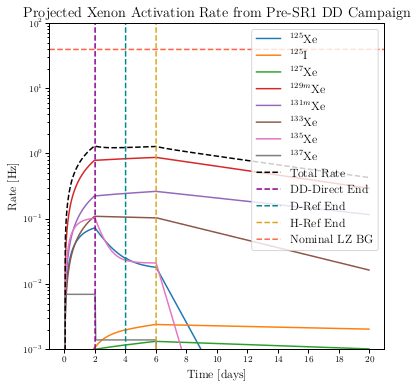

In [78]:
STEP_SIZE_DAYS = 1/24
TOTAL_DAYS = 60
RATE_PLOT_DAYS = 20
t_days = np.arange(0, TOTAL_DAYS, STEP_SIZE_DAYS)
index = np.argwhere(t_days == RATE_PLOT_DAYS)[0,0]

total_rate_Hz = np.zeros_like(t_days)

fig, ax = plt.subplots(figsize=(6,6))
LOWER_BOUND_Y = 1e-3
UPPER_BOUND_Y = 1e2
colors = plt.cm.tab20(np.linspace(0, 1, len(list(isotope_data["LiquidXenonTarget"].keys()))))
ax.set_prop_cycle(color=colors)
for isotope, counts in sorted(isotope_data["LiquidXenonTarget"].items()):
    if (isotope not in ISOTOPES):
        print(f"{isotope} not found")
    
    processes = ISOTOPES[isotope]["processes"]
    if ("RadioactiveDecay" in processes):
        children = processes["RadioactiveDecay"]["children"]
        child = list(children.keys())[0]
        half_life_days_parent = children[child]["half_life_days"]

        count_child = False
        processes = ISOTOPES[child]["processes"]
        if ("RadioactiveDecay" in processes):    
            children = processes["RadioactiveDecay"]["children"]
            grandchild = list(children.keys())[0]
            half_life_days_child = children[grandchild]["half_life_days"]
            count_child = True
       
        rate_Hz_parent = np.zeros_like(t_days)
        rate_Hz_child = np.zeros_like(t_days)
        D0_parent = [0, 0, 0]
        D0_child = [0, 0, 0]

        # Iterate through DD modes for isotope creation
        for i in range(0, 3):
            time = np.arange(run_starts_days[i], 
                             run_ends_days[i],
                             STEP_SIZE_DAYS)
            time = time - run_starts_days[i]
            creation_rate_per_day_parent = \
            ( 
                (counts*scale_factors[i])/(run_ends_days[i] - run_starts_days[i]) 
            )

            # Handle parent creation
            rate_per_day_parent = \
                creation_decay_rate(time,
                                    D0_parent[i],
                                    creation_rate_per_day_parent,
                                    half_life_days_parent)

            # Handle child creation
            if (count_child):
                rate_per_day_child = \
                    creation_decay_rate_child(time,
                                              D0_parent[i],
                                              creation_rate_per_day_parent,
                                              half_life_days_parent,
                                              D0_child[i], 
                                              half_life_days_child)
            else:
                rate_per_day_child = np.zeros_like(time)

            cut_time_window = \
            (
                (t_days >= run_starts_days[i])*(t_days < run_ends_days[i])
            )
            rate_Hz_parent[cut_time_window] = rate_per_day_parent/86400
            rate_Hz_child[cut_time_window] = rate_per_day_child/86400

            if (i < 2):
                D0_parent[i+1] = rate_per_day_parent[-1]
                D0_child[i+1] = rate_per_day_child[-1]

        # Handle decays after creation
        time = np.arange(run_ends_days[-1], t_days[-1], STEP_SIZE_DAYS)
        time = time - run_ends_days[-1]

        # Handle parent decay
        rate_per_day_parent = decay_rate(time, 
                                         rate_per_day_parent[-1],
                                         half_life_days_parent)

        # Handle child decay
        if (count_child):
            rate_per_day_child = decay_rate(time,
                                            rate_per_day_child[-1],
                                            half_life_days_child)

        else:
            rate_per_day_child = np.zeros_like(time)
        cut_time_window = (t_days >= run_ends_days[-1])*(t_days < t_days[-1])
        rate_Hz_parent[cut_time_window] = rate_per_day_parent/86400
        rate_Hz_child[cut_time_window]  = rate_per_day_child/86400

        ISOTOPES[isotope]["rate_Hz"] = rate_Hz_parent
        ISOTOPES[child]["rate_Hz"] = rate_Hz_child

        if (np.any(rate_Hz_parent > LOWER_BOUND_Y)):
            ax.plot(t_days[:index], rate_Hz_parent[:index], 
                    label=ISOTOPES[isotope]["label"])
        if (np.any(rate_Hz_child > LOWER_BOUND_Y)):
            ax.plot(t_days[:index], rate_Hz_child[:index], 
                    label=ISOTOPES[child]["label"])    
        total_rate_Hz += rate_Hz_parent
        total_rate_Hz += rate_Hz_child

ax.plot(t_days[:index], total_rate_Hz[:index], 
        label="Total Rate", color="k", linestyle="--")
ax.axvline(x=2, color="darkmagenta", linestyle="--", label="DD-Direct End")
ax.axvline(x=4, color="darkcyan", linestyle="--", label="D-Ref End")
ax.axvline(x=6, color="goldenrod", linestyle="--", label="H-Ref End")
ax.axhline(y=40, color="tomato", linestyle="--", label="Nominal LZ BG")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Rate [Hz]")
ax.set_xticks([2*i for i in range(11)])
ax.set_yscale("log")
ax.set_ylim([LOWER_BOUND_Y, UPPER_BOUND_Y])
ax.legend()
# ax.text(0.6, 0.20, 
#        """Xe129m and Xe131m
# rates inferred from Geant""",
#         transform=plt.gca().transAxes)
ax.set_title("Projected Xenon Activation Rate from Pre-SR1 DD Campaign")

if (use_tex):
    fig.savefig(f"{figure_dir}/rates_and_spectra/xenon_activation_rate.pdf",
                    dpi=FIG_DPI)
else:
    plt.show()

## Spectra

In [13]:
XE129M_E_KEV = 236.14
XE131M_E_KEV = 163.93
ACTIVE_MASS_KG = 7000
decay_time_days = t_days[-1] - run_ends_days[-1]

figure_dir = os.environ["FIGURE_DIR"]
spectrum_dir = os.environ["SPECTRUM_DATA_DIR"]

# spectrum_dir = "/users/wctaylor/data/baccarat/wctaylor-5.2.7/decays/processed"

aliases = \
{
    "event_numbers"     : "iEventNumber",
    "track_particle_ids": "tracks_iParticleID",
    "track_processes"   : "tracks_sCreatorProcess",
    "step_processes"    : "tracks_steps_sProcess",
    "step_energy_keV"   : "tracks_steps_dParticleEnergy_keV",
    "step_track_indices": "tracks_steps_iTrackArrayIndex",
    "step_x_mm"         : "tracks_steps_dPosition_mm_x",
    "step_y_mm"         : "tracks_steps_dPosition_mm_y",
    "step_z_mm"         : "tracks_steps_dPosition_mm_z",
}

fields = \
[
    "event_numbers",
    "track_particle_ids",
    "track_processes",
    "step_processes",
    "step_energy_keV",
    "step_track_indices",
    "step_x_mm",
    "step_y_mm",
    "step_z_mm"
]

bins = np.arange(0, 650, 5)
bin_width = bins[1] - bins[0]

### Xe125

In [15]:
isotope = "Xe125"
CHANNELS = \
{
    "I[243 keV] + K-shell": 243.382 + 33.1694,
    "I[243 keV] + L-shell": 243.382 + 5.1881,
    "I[243 keV] + M-shell": 243.382 + 1.0721,
    "I[188 keV] + K-shell": 188.416 + 33.1694,
    "I[188 keV] + L-shell": 188.416 + 5.1881,
    "I[188 keV] + M-shell": 188.416 + 1.0721,
    "I[454 keV] + K-shell": 453.792 + 33.1694,
    "I[454 keV] + L-shell": 453.792 + 5.1881,
    "I[454 keV] + M-shell": 453.792 + 1.0721,
    "I[372 keV] + K-shell": 372.066 + 33.1694,
    "I[372 keV] + L-shell": 372.066 + 5.1881,
    "I[372 keV] + M-shell": 372.066 + 1.0721
}

spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["I125"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases)
spectrum = None
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        centers, counts, errors = thesis.analysis.hist(E_flat[cut_channel_E], 
                                                       bins=bins, 
                                                       scale_factor=1/num_decays)
        if (spectrum is None):
            spectrum = \
            {
                "centers": centers,
                "counts": counts,
            }
        else:
            spectrum["counts"] += counts
ISOTOPES[isotope]["hist"] = spectrum

## I125

In [19]:
isotope = "I125"
CHANNELS = \
{
    "Te[35 keV] + K-shell": 35.4925 + 31.8138,
    "Te[35 keV] + L-shell": 35.4925 + 4.9392,
    "Te[35 keV] + M-shell": 35.4925 + 1.0060,
}

spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Te125"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases)

spectrum = None
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        centers, counts, errors = thesis.analysis.hist(E_flat[cut_channel_E], 
                                                       bins=bins, 
                                                       scale_factor=1/num_decays)
        if (spectrum is None):
            spectrum = \
            {
                "centers": centers,
                "counts": counts,
            }
        else:
            spectrum["counts"] += counts
ISOTOPES[isotope]["hist"] = spectrum

### Xe127

In [21]:
isotope = "Xe127"
CHANNELS = \
{
    "I[203 keV] + K-shell": 202.860 + 33.1694,
    "I[203 keV] + L-shell": 202.860 + 5.1881,
    "I[203 keV] + M-shell": 202.860 + 1.0721,
    "I[375 keV] + K-shell": 374.992 + 33.1694,
    "I[375 keV] + L-shell": 374.992 + 5.1881,
    "I[375 keV] + M-shell": 374.992 + 1.0721,
#     "I[618 keV] + K-shell": 618.4 + 33.1694,
#     "I[618 keV] + L-shell": 618.4 + 5.1881,
#     "I[618 keV] + M-shell": 618.4 + 1.0721
}

spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["I127"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases)

spectrum = None
for channel, energy in CHANNELS.items():
    cut_channel_E = (E_flat > (energy - bin_width/2)) * (E_flat < (energy + bin_width/2))
    if (np.any(cut_channel_E)):
        centers, counts, errors = thesis.analysis.hist(E_flat[cut_channel_E], 
                                                       bins=bins, 
                                                       scale_factor=1/num_decays)
        if (spectrum is None):
            spectrum = \
            {
                "centers": centers,
                "counts": counts,
            }
        else:
            spectrum["counts"] += counts
ISOTOPES[isotope]["hist"] = spectrum

### Xe129m

In [50]:
isotope = "Xe129m"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Xe129"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=True)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Xe131m

In [52]:
isotope = "Xe131m"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Xe131"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=True)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Xe133

In [37]:
isotope = "Xe133"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Cs133"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=False)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Xe135

In [38]:
isotope = "Xe135"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Cs135"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=False)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Cs135

In [40]:
isotope = "Cs135"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Ba135"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=False)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Xe137

In [41]:
isotope = "Xe137"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Cs137"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=False)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Cs137

In [42]:
isotope = "Cs137"
spectrum_file = (thesis.isotopes.ISOTOPES[isotope]
                 ["processes"]["RadioactiveDecay"]
                 ["children"]["Ba137"]["spectrum"])
filepath = f"{spectrum_dir}/{spectrum_file}"
num_decays, E_flat = thesis.analysis.get_decay_spectrum(filepath, 
                                                        fields, 
                                                        aliases, 
                                                        metastable=False)

centers, counts, errors = thesis.analysis.hist(E_flat, 
                                               bins=bins, 
                                               scale_factor=1/num_decays)
spectrum = \
{
    "centers": centers,
    "counts": counts,
}
ISOTOPES[isotope]["hist"] = spectrum

### Plot

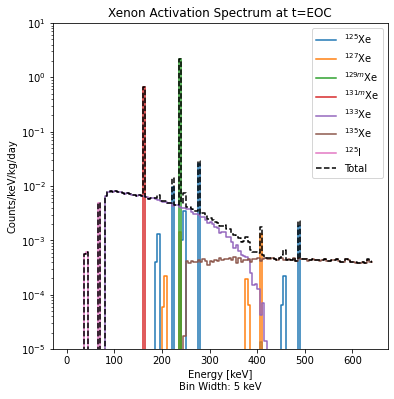

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
LOWER_BOUND_Y = 1e-5
UPPER_BOUND_Y = 1e1
colors = plt.cm.tab20(np.linspace(0, 1, len(list(isotope_data["LiquidXenonTarget"].keys()))))
ax.set_prop_cycle(color=colors)

total_spectrum = np.zeros_like(bins[:-1], dtype=np.float64)
for isotope, attributes in ISOTOPES.items():
    if ("hist" in attributes):
        index = np.argwhere(t_days == run_ends_days[-1])[0,0]
        # cumulative_decays = np.sum(  attributes["rate_Hz"][index:]
        #                            * STEP_SIZE_DAYS*86400  )
        
        centers = attributes["hist"]["centers"]
        counts = attributes["hist"]["counts"]
        counts_dru = counts*attributes["rate_Hz"][index]*86400/ACTIVE_MASS_KG
        # counts_dru = counts*cumulative_decays/ACTIVE_MASS_KG/decay_time_days
        # errors_dru  = attributes["hist"][2]*cumulative_decays/ACTIVE_MASS_KG/decay_time_days
        
        total_spectrum += counts_dru
        if (np.any(counts_dru > LOWER_BOUND_Y)):
            ax.step(centers, counts_dru, where="mid", 
                    label=attributes["label"])
            # ax.errorbar(centers, counts_dru, yerr=errors_dru, 
                        # fmt="none")
        
        #plt.step(centers, counts, where='mid', label=isotope, color=attributes['color'])
        #plt.errorbar(centers, counts, yerr=errors, fmt="none", color=attributes['color'])
ax.step(centers, total_spectrum, where="mid", color="k", linestyle="--", 
        label="Total")
ax.set_yscale("log")
ax.set_ylim([LOWER_BOUND_Y, UPPER_BOUND_Y])
ax.set_xlabel(f"Energy [keV]\n"
              f"Bin Width: {bin_width:.0f} keV")
ax.set_ylabel("Counts/keV/kg/day")
ax.legend()
ax.set_title("Xenon Activation Spectrum at t=EOC")

if (use_tex):
    fig.savefig(f"{figure_dir}/rates_and_spectra/xenon_activation_spectrum_eoc.pdf",
                    dpi=FIG_DPI)
else:
    plt.show()

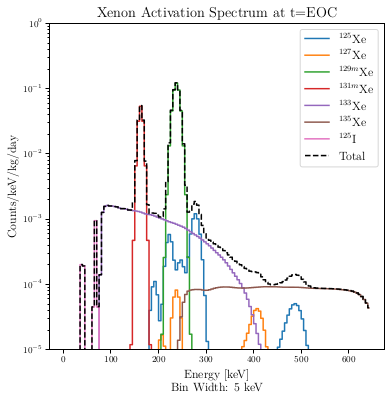

In [80]:
fig, ax = plt.subplots(figsize=(6,6))
LOWER_BOUND_Y = 1e-5
UPPER_BOUND_Y = 1e0
colors = plt.cm.tab20(np.linspace(0, 1, len(list(isotope_data["LiquidXenonTarget"].keys()))))
ax.set_prop_cycle(color=colors)

total_spectrum = np.zeros_like(bins[:-1], dtype=np.float64)
for isotope, attributes in ISOTOPES.items():
    if ("hist" in attributes):
        index = np.argwhere(t_days == run_ends_days[-1])[0,0]
        
        centers = attributes["hist"]["centers"]
        counts = attributes["hist"]["counts"]
        
        spectrum = np.zeros_like(centers)
        for i in range(len(counts)):
            resolution = centers[i]*0.03
            dist = (counts[i])*gauss(centers, 
                                     centers[i], 
                                     resolution, 
                                     normed=True)
            spectrum += dist
        counts_dru = spectrum*attributes["rate_Hz"][index]*86400/ACTIVE_MASS_KG
        total_spectrum += counts_dru
        
        if (np.any(counts_dru > LOWER_BOUND_Y)):
            ax.step(centers, counts_dru, where="mid", 
                    label=attributes["label"])

ax.step(centers, total_spectrum, where="mid", color="k", linestyle="--", 
        label="Total")
ax.set_yscale("log")
ax.set_ylim([LOWER_BOUND_Y, UPPER_BOUND_Y])
ax.set_xlabel(f"Energy [keV]\n"
              f"Bin Width: {bin_width:.0f} keV")
ax.set_ylabel("Counts/keV/kg/day")
ax.legend()
ax.set_title("Xenon Activation Spectrum at t=EOC")

if (use_tex):
    fig.savefig(f"{figure_dir}/rates_and_spectra/xenon_activation_spectrum_eoc_gauss.pdf",
                    dpi=FIG_DPI)
else:
    plt.show()

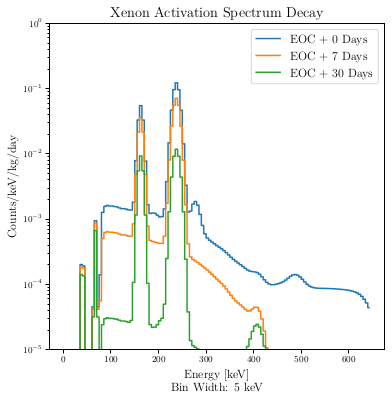

In [82]:
fig, ax = plt.subplots(figsize=(6,6))
LOWER_BOUND_Y = 1e-5
UPPER_BOUND_Y = 1e0
colors = plt.cm.tab20(np.linspace(0, 1, len(list(isotope_data["LiquidXenonTarget"].keys()))))
ax.set_prop_cycle(color=colors)

time_days_after_eoc = [0, 7, 30]

for t in time_days_after_eoc:
    total_spectrum = np.zeros_like(bins[:-1], dtype=np.float64)
    for isotope, attributes in ISOTOPES.items():
        if ("hist" in attributes):
            t_index = run_ends_days[-1] + t
            index = np.argwhere(t_days == t_index)[0,0]

            centers = attributes["hist"]["centers"]
            counts = attributes["hist"]["counts"]

            spectrum = np.zeros_like(centers)
            for i in range(len(counts)):
                resolution = centers[i]*0.03
                dist = (counts[i])*gauss(centers, 
                                         centers[i], 
                                         resolution, 
                                         normed=True)
                spectrum += dist
            counts_dru = spectrum*attributes["rate_Hz"][index]*86400/ACTIVE_MASS_KG
            total_spectrum += counts_dru

            # if (np.any(counts_dru > LOWER_BOUND_Y)):
            #     ax.step(centers, counts_dru, where="mid", 
            #             label=attributes["label"])

    ax.step(centers, total_spectrum, where="mid", 
        label=f"EOC + {t} Days")

ax.set_yscale("log")
ax.set_ylim([LOWER_BOUND_Y, UPPER_BOUND_Y])
ax.set_xlabel(f"Energy [keV]\n"
              f"Bin Width: {bin_width:.0f} keV")
ax.set_ylabel("Counts/keV/kg/day")
ax.legend()
ax.set_title("Xenon Activation Spectrum Decay")

if (use_tex):
    fig.savefig(f"{figure_dir}/rates_and_spectra/xenon_activation_spectrum_decay_gauss.pdf",
                    dpi=FIG_DPI)
else:
    plt.show()